# Exploratory notebook 1 
## Bengali speech recognition
### AUDIO 

This notebook is part of the exploratory work for the Kaggle competition Bengali.AI. 

The goal is to transcribe audio from bengali speakers into written form. 
This notebook will focus on the audio part. The second notebook on the text part. 


In [1]:
import pandas as pd 
import soundfile as sf
from pathlib import Path
import IPython
import numpy as np 
import matplotlib.pyplot as plt
from pydub import AudioSegment

In [2]:
root         = Path("/disk3/clara/bengali")
audio_folder = root / "train_mp3s"
df = pd.read_csv(root / "train.csv")
print("Data shape : ", df.shape)
df.head()

Data shape :  (963636, 3)


,id,sentence,split
0,000005f3362c,ও বলেছে আপনার ঠিকানা!,train
1,00001dddd002,কোন মহান রাষ্ট্রের নাগরিক হতে চাও?,train
2,00001e0bc131,"আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।",train
3,000024b3d810,নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন...,train
4,000028220ab3,"হুমম, ওহ হেই, দেখো।",train


In [3]:
df["full_path"] = df.apply(lambda row : audio_folder / f"{row.id}.mp3", axis=1)

In [4]:
!du -h /disk3/clara/bengali/train_mp3s

26G	/disk3/clara/bengali/train_mp3s


The training database is composed of more than 900.000 row. 

Each row corresponds to an audio id that can me found in the train_mp3s folder as "id".mp3 file name. 

This folder takes **23G in memory**. 
Sentences are written in bengali alphabet. 

Let's take a sample for exploratory work. 

Path :  /disk3/clara/bengali/train_mp3s/000005f3362c.mp3 sample rate :  32000  Hz
Transcript :  ও বলেছে আপনার ঠিকানা!


Path :  /disk3/clara/bengali/train_mp3s/00001dddd002.mp3 sample rate :  32000  Hz
Transcript :  কোন মহান রাষ্ট্রের নাগরিক হতে চাও?


Path :  /disk3/clara/bengali/train_mp3s/00001e0bc131.mp3 sample rate :  32000  Hz
Transcript :  আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।


Path :  /disk3/clara/bengali/train_mp3s/000024b3d810.mp3 sample rate :  32000  Hz
Transcript :  নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন করেন।


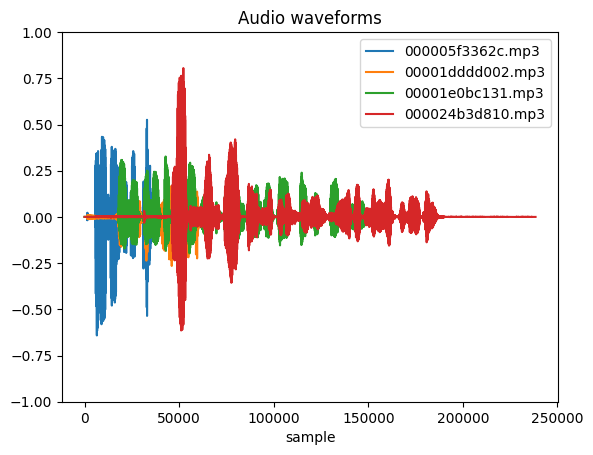

In [5]:
for i in range(4) : 
    id = df.iloc[i]["id"]
    audio_path = audio_folder / f"{id}.mp3"
    audio , sr = sf.read(audio_path)
    print("Path : ", audio_path, "sample rate : ", sr, " Hz")
    print("Transcript : ", df.iloc[i]["sentence"])
    plt.plot(audio, label=f"{id}.mp3" )
    plt.xlabel("sample")
    plt.ylim([-1,1])
    
    IPython.display.display(IPython.display.Audio(audio_path))
plt.title("Audio waveforms")
plt.legend()
plt.show()

First of all, each audio file does not have the same length. Speaker are easer male of female. 

The sound level is different for each audio, some are more noisy then others.

Some transcription also have punctuation. 



In [9]:
df = df.sample(int(df.shape[0] * 0.1))

In [10]:
def get_audio_length(row) : 
    audio, sr = sf.read(audio_folder / f"{row.id}.mp3")
    return len(audio) / sr
df["duration"] = df.apply(get_audio_length, axis=1)
print("Total duration : ", df["duration"].sum()) 

Total duration :  425200.068


In [21]:
df.shape

(96363, 5)

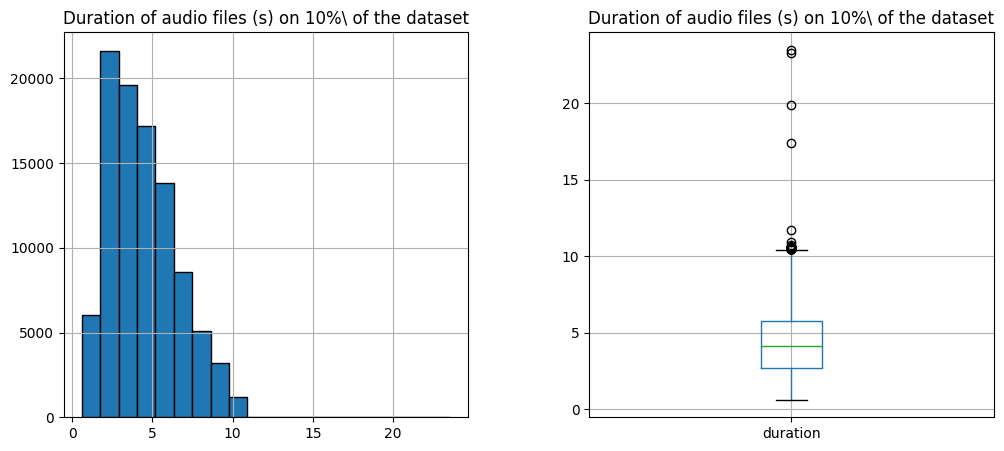

In [20]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
df.hist( column=["duration"], edgecolor='black', bins=20, ax=ax1)
df.boxplot(column=["duration"],ax=ax2)
ax1.set_title("Duration of audio files (s) on 10%\ of the dataset")
ax2.set_title("Duration of audio files (s) on 10%\ of the dataset")

plt.show()


In [12]:
def get_sampling_rate(row): 
    _, sr = sf.read(audio_folder / f"{row.id}.mp3")
    return sr

df["fs"] = df.apply(get_sampling_rate, axis=1)
df["fs"].unique()

KeyboardInterrupt: 

The only sample rate of all files is **32kHz** . 

## And the sound level ? 
### What are the different sound level of all audio files : 
In digital audio we use **dBFS (decibels relative to full scale)** as reference to  measure audio level. 

dBFS is expressed as a negative number relative to the maximum level available in a digital system.

In [ ]:
def get_dBFs(row): 
    sound = AudioSegment.from_file(audio_folder / f"{row.id}.mp3", format="mp3")
    return  sound.dBFS

df["dBFS"] = df.apply(get_dBFs, axis=1)


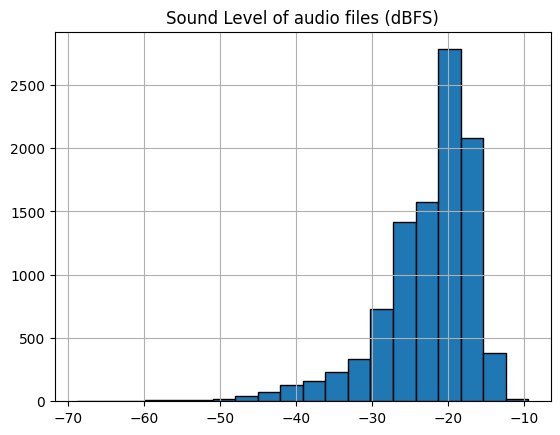

In [ ]:
df.hist( column=["dBFS"], edgecolor='black', bins=20)
plt.title("Sound Level of audio files (dBFS)")
plt.show()

In [ ]:
IPython.display.display(IPython.display.Audio(df[df["dBFS"] < -50].iloc[0]["full_path"]))

It's clear that we do not ear anything. 

In [ ]:
IPython.display.display(IPython.display.Audio(df[df["dBFS"] > -10].iloc[0]["full_path"]))

It's very loud and the sound is saturating. 

# Male or female ? 
Let's use alefiury/wav2vec2-large-xlsr-53-gender-recognition-librispeech to label our data extract.

In [ ]:
from data_cleaning.gender_recognition import get_gender_list

paths = df["full_path"].to_list()
preds = get_gender_list(paths)

100%|██████████| 625/625 [02:08<00:00,  4.85it/s]


In [ ]:
print(f"Number of female : {len(preds) - np.sum(preds)} over {len(preds)}, {(len(preds) - np.sum(preds))/len(preds) *100} % ")
print(f"Number of male : {np.sum(preds)} over {len(preds)}, {(np.sum(preds))/len(preds) *100} % ")

Number of female : 4911 over 10000, 49.11 % 
Number of male : 5089 over 10000, 50.89 % 


The data seems to be balanced.

In [ ]:
df.to_csv(root / "ex1_train.csv", index_col=False)

## Conclusion 
The audio data contains lot of noise of different nature and are of variable length.
Very long audio will damage training and need to be set apart (first clean then considered if time). 
Audio below -50dBFS and over -5dBFS needs to be taken also apart. 
